In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os
%matplotlib inline

In [13]:
class MD_based_RS:
    """
    类说明： 基于矩阵分解的推荐系统
    """
    def __init__(self,R,W,TR,TW,Parameters):
        """
        函数说明：初始化推荐系统所需参数
        参数说明：
            R - 评分矩阵
            W - 权重矩阵
            TR - 测试评分矩阵
            TW - 测试权重矩阵
            Parameters - 超参数
        """
        self.Rating_Matrix=R
        self.n_rows=Parameters['n_rows']
        self.n_cols=Parameters['n_cols']
        self.K=Parameters['K']    #潜在特征数，通常在10-100间
        self.penalty_factor=Parameters['penalty_factor']    #惩罚因子
        self.max_loops=Parameters['max_loops']
        self.epsilon=Parameters['epsilon']    #判断收敛
        
        self.Weight_Matrix=W
        self.Test_Rating_Matrix=TR
        self.Test_Weight_Matrix=TW
        
        #self.P_users;    #用户因子矩阵
        #self.Q_item;    #物品因子矩阵
        
    def RMSE(self,Rating_Matrix):
        """
        函数说明：计算均方差
        参数说明：
            Rating_Matrix - 上一轮评分矩阵
        返回值：均方差
        """
        
        Predict=self.P_users.dot(self.Q_item.T)
        rmse=np.sqrt((np.asarray((Rating_Matrix-Predict))**2).sum()/(self.n_rows*self.n_cols))
        return rmse
    
    def loss(self,Rating_Matrix,Weight_Matrix):
        """
        函数说明：计算loss
        参数说明：
            Rating_Matrix - 上一轮评分矩阵
            Weight_Matrix - 权重矩阵
        """
        Predict=self.P_users.dot(self.Q_item.T)
        SEL=np.sum((Weight_Matrix*np.asarray(Rating_Matrix-Predict))**2)
        RP=0
        RQ=0
        for i in range(0,self.n_rows):
            RP+=self.penalty_factor*self.P_users[i,:].dot(self.P_users[i,:].T)
        for i in range(0,self.n_cols):
            RQ+=self.penalty_factor*self.Q_item[i,:].dot(self.Q_item[i,:].T)
        LOSS=SEL+RP+RQ
        return LOSS/(self.n_rows*self.n_cols)
    
    def iteration(self,matrix_fixed):
        """
        函数说明：每一次迭代更新矩阵
        参数说明：
            matrix_fixed - 更新后的矩阵
        """
        tic=time.time
        if matrix_fixed=="P_users":
            solve_vecs=np.linalg.solve(np.dot(self.P_users.T,self.P_users)+
                                      self.penalty_factor*np.eye(self.K),
                                     np.dot(self.P_users.T,self.Rating_Matrix)).T
        else:
            solve_vecs=np.linalg.solve(np.dot(self.Q_item.T,self.Q_item)+
                                       self.penalty_factor*np.eye(self.K),
                                      np.dot(self.Q_item.T,self.Rating_Matrix.T)).T
        #print('更新 {} 成功，用时:{:0.5f}s'.format(matrix_fixed,time.time()-tic))
        return solve_vecs
    
    def draw(self):
        """
        函数说明：画图
        """
        loops=self.max_loops
        plt.plot(np.arange(0,loops-1,1),self.train_Rmse[0:loops-1],label='Train_RMSE')
        plt.plot(np.arange(0, loops - 1, 1), self.test_Rmse[0:loops - 1], label='Test_RMSE')
        plt.xlabel('loops')
        plt.ylabel('RMSE')
        plt.title('RMSE')
        plt.legend()
        plt.show()
        
        loops=self.max_loops
        plt.plot(np.arange(0, loops - 1, 1), self.test_Loss[0:loops - 1], label='Test_Loss')
        plt.plot(np.arange(0, loops - 1, 1), self.train_Loss[0:loops - 1], label='Train_Loss')
        plt.xlabel('loops')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()
        plt.show()
        
    def train(self):
        """
        函数说明：训练因子矩阵
        """
        tic=time.time()
        self.train_Rmse=[]
        self.train_Loss=[]
        self.test_Rmse=[]
        self.test_Loss=[]
        self.P_users=np.random.normal(size=(self.n_rows,self.K))
        self.Q_item=np.random.normal(size=(self.n_cols,self.K))
        count=0
        rmse=1
        
        while count<self.max_loops:
            if rmse<self.epsilon:
                print("finish，循环次数：{}，用时：{:0.2f}秒".format(count,time.time()-tic))
                break
            else:
                print("第{}次更新用户因子矩阵".format(count))
                self.P_users=self.iteration('Q_item')
                print("第{}次更新物品因子矩阵".format(count))
                self.Q_item=self.iteration("P_users")
                
                #记录RMSE和LOSS
                train_rmse=self.RMSE(self.Rating_Matrix)
                train_loss=self.loss(self.Rating_Matrix,self.Weight_Matrix)
                test_rmse=self.RMSE(self.Test_Rating_Matrix)
                test_loss=self.loss(self.Test_Rating_Matrix,self.Test_Weight_Matrix)
                
                self.train_Rmse.append(train_rmse)
                self.train_Loss.append(train_loss)
                self.test_Rmse.append(test_rmse)
                self.test_Loss.append(test_loss)
                
                print('Loops:{} Completed. Train: RMSE:{:0.2f},Loss:{:0.2f}; Test: RMSE:{:0.2f},Loss:{:0.2f}'
                      .format(count, train_rmse,train_loss,test_rmse,test_loss))
                
                count=count+1
            print("预测完毕，循环次数：{}，用时：{:0.2f}秒".format(count,time.time()-tic))
    

In [9]:
def loadMovieLens(parameters,directory_path):
    """
    函数说明：导入数据集,mode==0,原始数据集；mode=1，已切分数据集
    参数说明：
        parameters - 一组超参
        directory_path - 数据集路径
    """
    tic=time.time()
    n_rows=parameters['n_rows']
    n_cols=parameters['n_cols']
    mode=parameters['mode']
    
    if mode==0:
        file_path=directory_path+'/u.data'
        Train_Rating_Matrix=np.zeros(shape=(n_rows,n_cols))
        Train_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
        Test_Rating_Matrix=np.zeros(shape=(n_rows,n_cols))
        Test_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
        origin_data=np.loadtxt(file_path)
        train,test=train_test_split(origin_data,test_size=0.2,random_state=1)
        for i in range(0,train.shape[0]):
            user_id=int(train[i][0])
            item_id=int(train[i][1])
            rating=train[i][2]
            Train_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Train_Weight_Matrix[user_id - 1, item_id - 1] = rating
        for i in range(0,test.shape[0]):
            user_id=int(test[i][0])
            item_id=int(test[i][1])
            rating=test[i][2]
            Test_Rating_Matrix[user_id-1,item_id-1]=rating
            if rating!=0:
                Test_Weight_Matrix[user_id - 1, item_id - 1] = rating
        print('导入数据集成功。 用时:{:0.2f}. Mode: Hold-Out'.format(time.time()-tic))
        return Train_Rating_Matrix,Train_Weight_Matrix,Test_Rating_Matrix,Test_Weight_Matrix
    
    if mode==1:
        Train_Rating_Matrixs=[]
        Train_Weight_Matrixs=[]
        Test_Rating_Matrixs=[]
        Test_Weight_Matrixs=[]
        for i in range(1,6):
            Train_Rating_Matrix = np.zeros(shape=(n_rows, n_cols))
            Train_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
            Test_Rating_Matrix = np.zeros(shape=(n_rows, n_cols))
            Test_Weight_Matrix = np.zeros(shape=(n_rows, n_cols))
            train_path = directory_path + '/u{}.base'.format(i)
            test_path = directory_path + '/u{}.test'.format(i)
            train_data = np.loadtxt(train_path)
            test_data = np.loadtxt(test_path)
            for i in range(0, train_data.shape[0]):
                user_id = int(train_data[i][0])
                item_id = int(train_data[i][1])
                rating = train_data[i][2]
                Train_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Train_Weight_Matrix[user_id - 1, item_id - 1] = rating
            for i in range(0, test_data.shape[0]):
                user_id = int(test_data[i][0])
                item_id = int(test_data[i][1])
                rating = test_data[i][2]
                Test_Rating_Matrix[user_id - 1, item_id - 1] = rating
                if rating != 0:
                    Test_Weight_Matrix[user_id - 1, item_id - 1] = rating
            Train_Rating_Matrixs.append(Train_Rating_Matrix)
            Train_Weight_Matrixs.append(Train_Weight_Matrix)
            Test_Rating_Matrixs.append(Test_Rating_Matrix)
            Test_Weight_Matrixs.append(Test_Weight_Matrix)
        print('导入数据集成功。 用时:{:0.2f}. Mode: Cross validation'.format(time.time()-tic))
        Data=[Train_Rating_Matrixs,Train_Weight_Matrixs,Test_Rating_Matrixs,Test_Rating_Matrixs]
        return Data
    

In [10]:
def draw(loops,dic,x_label,y_label,title):
    loops = loops
    for m_label,list in dic.items():
        plt.plot(np.arange(0, loops - 1, 1), list[0:loops - 1], label=m_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

导入数据集成功。 用时:0.95. Mode: Hold-Out
第0次更新用户因子矩阵
第0次更新物品因子矩阵
Loops:0 Completed. Train: RMSE:0.67,Loss:6.27; Test: RMSE:0.54,Loss:2.01
预测完毕，循环次数：1，用时：0.19秒
第1次更新用户因子矩阵
第1次更新物品因子矩阵
Loops:1 Completed. Train: RMSE:0.60,Loss:4.60; Test: RMSE:0.61,Loss:1.79
预测完毕，循环次数：2，用时：0.37秒
第2次更新用户因子矩阵
第2次更新物品因子矩阵
Loops:2 Completed. Train: RMSE:0.59,Loss:4.36; Test: RMSE:0.62,Loss:1.80
预测完毕，循环次数：3，用时：0.56秒
第3次更新用户因子矩阵
第3次更新物品因子矩阵
Loops:3 Completed. Train: RMSE:0.59,Loss:4.26; Test: RMSE:0.63,Loss:1.80
预测完毕，循环次数：4，用时：0.80秒
第4次更新用户因子矩阵
第4次更新物品因子矩阵
Loops:4 Completed. Train: RMSE:0.59,Loss:4.20; Test: RMSE:0.63,Loss:1.80
预测完毕，循环次数：5，用时：0.99秒
第5次更新用户因子矩阵
第5次更新物品因子矩阵
Loops:5 Completed. Train: RMSE:0.59,Loss:4.17; Test: RMSE:0.63,Loss:1.80
预测完毕，循环次数：6，用时：1.21秒
第6次更新用户因子矩阵
第6次更新物品因子矩阵
Loops:6 Completed. Train: RMSE:0.58,Loss:4.14; Test: RMSE:0.64,Loss:1.80
预测完毕，循环次数：7，用时：1.44秒
第7次更新用户因子矩阵
第7次更新物品因子矩阵
Loops:7 Completed. Train: RMSE:0.58,Loss:4.12; Test: RMSE:0.64,Loss:1.80
预测完毕，循环次数：8，用时：1.62秒
第8次更新用户因子矩阵
第8次更新物品因子矩阵

Loops:67 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：68，用时：13.05秒
第68次更新用户因子矩阵
第68次更新物品因子矩阵
Loops:68 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：69，用时：13.27秒
第69次更新用户因子矩阵
第69次更新物品因子矩阵
Loops:69 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：70，用时：13.44秒
第70次更新用户因子矩阵
第70次更新物品因子矩阵
Loops:70 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：71，用时：13.60秒
第71次更新用户因子矩阵
第71次更新物品因子矩阵
Loops:71 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：72，用时：13.82秒
第72次更新用户因子矩阵
第72次更新物品因子矩阵
Loops:72 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：73，用时：14.01秒
第73次更新用户因子矩阵
第73次更新物品因子矩阵
Loops:73 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：74，用时：14.19秒
第74次更新用户因子矩阵
第74次更新物品因子矩阵
Loops:74 Completed. Train: RMSE:0.58,Loss:3.97; Test: RMSE:0.65,Loss:1.78
预测完毕，循环次数：75，用时：14.37秒
第75次更新用户因子矩阵
第75次更新物品因子矩阵
Loops:75 Complet

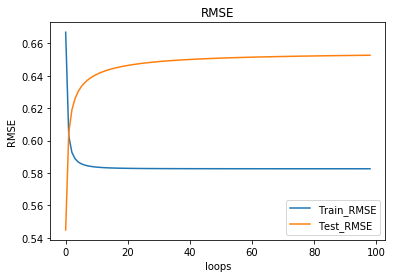

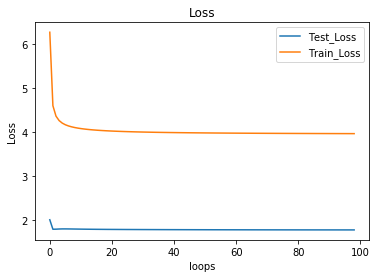

In [11]:

if __name__ == '__main__':

    #设置两种情况下的超参
    prefix=os.getcwd()
    dic_path=prefix+'/ml-100k'
    # Use the full dataset:u.data
    Parameters_1={
        'n_rows':943,
        'n_cols':1682,
        'mode':0,
        'K':40,
        'penalty_factor':0.1,
        'max_loops':100,
        'epsilon':0.00001
    }
    # Use the five divided dataset
    Parameters_2={
        'n_rows':943,
        'n_cols':1682,
        'mode':1,
        'K':40,
        'penalty_factor':0.1,
        'max_loops':100,
        'epsilon':0.00001
    }
    
    #使用整个数据集训练一个模型
    Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix = loadMovieLens(Parameters_1,dic_path)
    fModel_0 = MD_based_RS(Train_Rating_Matrix, Train_Weight_Matrix, Test_Rating_Matrix, Test_Weight_Matrix, Parameters_1)
    fModel_0.train()
    fModel_0.draw()
    
    

导入数据集成功。 用时:4.71. Mode: Cross validation
开始训练 Model_0
第0次更新用户因子矩阵
第0次更新物品因子矩阵
Loops:0 Completed. Train: RMSE:0.65,Loss:5.96; Test: RMSE:0.58,Loss:2.28
预测完毕，循环次数：1，用时：0.23秒
第1次更新用户因子矩阵
第1次更新物品因子矩阵
Loops:1 Completed. Train: RMSE:0.59,Loss:4.40; Test: RMSE:0.64,Loss:2.10
预测完毕，循环次数：2，用时：0.39秒
第2次更新用户因子矩阵
第2次更新物品因子矩阵
Loops:2 Completed. Train: RMSE:0.58,Loss:4.18; Test: RMSE:0.65,Loss:2.09
预测完毕，循环次数：3，用时：0.57秒
第3次更新用户因子矩阵
第3次更新物品因子矩阵
Loops:3 Completed. Train: RMSE:0.58,Loss:4.09; Test: RMSE:0.66,Loss:2.09
预测完毕，循环次数：4，用时：0.73秒
第4次更新用户因子矩阵
第4次更新物品因子矩阵
Loops:4 Completed. Train: RMSE:0.57,Loss:4.04; Test: RMSE:0.66,Loss:2.10
预测完毕，循环次数：5，用时：0.88秒
第5次更新用户因子矩阵
第5次更新物品因子矩阵
Loops:5 Completed. Train: RMSE:0.57,Loss:4.00; Test: RMSE:0.66,Loss:2.10
预测完毕，循环次数：6，用时：1.05秒
第6次更新用户因子矩阵
第6次更新物品因子矩阵
Loops:6 Completed. Train: RMSE:0.57,Loss:3.98; Test: RMSE:0.66,Loss:2.10
预测完毕，循环次数：7，用时：1.21秒
第7次更新用户因子矩阵
第7次更新物品因子矩阵
Loops:7 Completed. Train: RMSE:0.57,Loss:3.96; Test: RMSE:0.67,Loss:2.10
预测完毕，循环次数：8，用时：1.37秒
第8

Loops:67 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：68，用时：13.37秒
第68次更新用户因子矩阵
第68次更新物品因子矩阵
Loops:68 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：69，用时：13.57秒
第69次更新用户因子矩阵
第69次更新物品因子矩阵
Loops:69 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：70，用时：13.74秒
第70次更新用户因子矩阵
第70次更新物品因子矩阵
Loops:70 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：71，用时：13.93秒
第71次更新用户因子矩阵
第71次更新物品因子矩阵
Loops:71 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：72，用时：14.08秒
第72次更新用户因子矩阵
第72次更新物品因子矩阵
Loops:72 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：73，用时：14.22秒
第73次更新用户因子矩阵
第73次更新物品因子矩阵
Loops:73 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：74，用时：14.37秒
第74次更新用户因子矩阵
第74次更新物品因子矩阵
Loops:74 Completed. Train: RMSE:0.57,Loss:3.83; Test: RMSE:0.68,Loss:2.08
预测完毕，循环次数：75，用时：14.52秒
第75次更新用户因子矩阵
第75次更新物品因子矩阵
Loops:75 Complet

Loops:34 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：35，用时：6.88秒
第35次更新用户因子矩阵
第35次更新物品因子矩阵
Loops:35 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：36，用时：7.13秒
第36次更新用户因子矩阵
第36次更新物品因子矩阵
Loops:36 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：37，用时：7.37秒
第37次更新用户因子矩阵
第37次更新物品因子矩阵
Loops:37 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：38，用时：7.62秒
第38次更新用户因子矩阵
第38次更新物品因子矩阵
Loops:38 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：39，用时：7.77秒
第39次更新用户因子矩阵
第39次更新物品因子矩阵
Loops:39 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：40，用时：7.96秒
第40次更新用户因子矩阵
第40次更新物品因子矩阵
Loops:40 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：41，用时：8.18秒
第41次更新用户因子矩阵
第41次更新物品因子矩阵
Loops:41 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：42，用时：8.38秒
第42次更新用户因子矩阵
第42次更新物品因子矩阵
Loops:42 Completed. Trai

Loops:69 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：70，用时：14.58秒
第70次更新用户因子矩阵
第70次更新物品因子矩阵
Loops:70 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：71，用时：14.72秒
第71次更新用户因子矩阵
第71次更新物品因子矩阵
Loops:71 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：72，用时：14.86秒
第72次更新用户因子矩阵
第72次更新物品因子矩阵
Loops:72 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：73，用时：15.01秒
第73次更新用户因子矩阵
第73次更新物品因子矩阵
Loops:73 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：74，用时：15.15秒
第74次更新用户因子矩阵
第74次更新物品因子矩阵
Loops:74 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：75，用时：15.29秒
第75次更新用户因子矩阵
第75次更新物品因子矩阵
Loops:75 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：76，用时：15.43秒
第76次更新用户因子矩阵
第76次更新物品因子矩阵
Loops:76 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.84
预测完毕，循环次数：77，用时：15.59秒
第77次更新用户因子矩阵
第77次更新物品因子矩阵
Loops:77 Complet

Loops:36 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：37，用时：7.78秒
第37次更新用户因子矩阵
第37次更新物品因子矩阵
Loops:37 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：38，用时：8.02秒
第38次更新用户因子矩阵
第38次更新物品因子矩阵
Loops:38 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：39，用时：8.20秒
第39次更新用户因子矩阵
第39次更新物品因子矩阵
Loops:39 Completed. Train: RMSE:0.58,Loss:3.93; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：40，用时：8.43秒
第40次更新用户因子矩阵
第40次更新物品因子矩阵
Loops:40 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：41，用时：8.60秒
第41次更新用户因子矩阵
第41次更新物品因子矩阵
Loops:41 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：42，用时：8.75秒
第42次更新用户因子矩阵
第42次更新物品因子矩阵
Loops:42 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：43，用时：8.93秒
第43次更新用户因子矩阵
第43次更新物品因子矩阵
Loops:43 Completed. Train: RMSE:0.58,Loss:3.92; Test: RMSE:0.66,Loss:1.85
预测完毕，循环次数：44，用时：9.12秒
第44次更新用户因子矩阵
第44次更新物品因子矩阵
Loops:44 Completed. Trai

Loops:3 Completed. Train: RMSE:0.58,Loss:4.09; Test: RMSE:0.65,Loss:1.94
预测完毕，循环次数：4，用时：0.70秒
第4次更新用户因子矩阵
第4次更新物品因子矩阵
Loops:4 Completed. Train: RMSE:0.58,Loss:4.04; Test: RMSE:0.65,Loss:1.94
预测完毕，循环次数：5，用时：0.86秒
第5次更新用户因子矩阵
第5次更新物品因子矩阵
Loops:5 Completed. Train: RMSE:0.58,Loss:4.01; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：6，用时：1.07秒
第6次更新用户因子矩阵
第6次更新物品因子矩阵
Loops:6 Completed. Train: RMSE:0.57,Loss:3.98; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：7，用时：1.29秒
第7次更新用户因子矩阵
第7次更新物品因子矩阵
Loops:7 Completed. Train: RMSE:0.57,Loss:3.97; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：8，用时：1.47秒
第8次更新用户因子矩阵
第8次更新物品因子矩阵
Loops:8 Completed. Train: RMSE:0.57,Loss:3.95; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：9，用时：1.63秒
第9次更新用户因子矩阵
第9次更新物品因子矩阵
Loops:9 Completed. Train: RMSE:0.57,Loss:3.94; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：10，用时：1.80秒
第10次更新用户因子矩阵
第10次更新物品因子矩阵
Loops:10 Completed. Train: RMSE:0.57,Loss:3.93; Test: RMSE:0.66,Loss:1.94
预测完毕，循环次数：11，用时：2.01秒
第11次更新用户因子矩阵
第11次更新物品因子矩阵
Loops:11 Completed. Train: RMSE:0.57,Loss:3.93; T

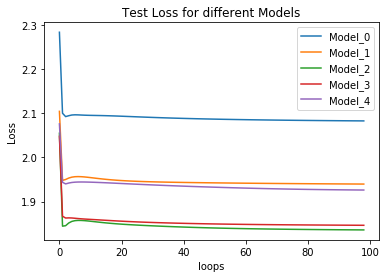

In [12]:
    #使用五个已切分的数据集训练五个不同的模型并画出曲线
    Data=loadMovieLens(Parameters_2,dic_path)
    Models=[]
    for i in range(0,5):
        tic=time.time()
        print('开始训练 Model_{}'.format(i))
        model=MD_based_RS(Data[0][i],Data[1][i],Data[2][i],Data[3][i],Parameters_2)
        model.train()
        print('Model_{} 训练完毕. 用时 {:0.2f}s'.format(i,time.time()-tic))
        Models.append(model)
    dic={'Model_0':Models[0].test_Loss,
         'Model_1': Models[1].test_Loss,
         'Model_2': Models[2].test_Loss,
         'Model_3': Models[3].test_Loss,
         'Model_4': Models[4].test_Loss,}
    draw(Parameters_2['max_loops'],dic,'loops','Loss','Test Loss for different Models')